<h3>IMPLEMENTATION OF <font color = "red">LINEAR REGRESSION</font> USING HOUSING PRICES  </h3>

<h5>Importing Necessary libraries </h5> 
<ol>
    <li>Seaborn for statistical visualization </li>
    <li>maplotlib for plot support </li>
</ol>

In [1]:
import os
import pandas as pd
import numpy as np
import sklearn
from sklearn import linear_model
import seaborn as sns #used for statistical data visualization
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt

<h5>Reading the file into a dataframe</h5>

In [2]:
os.chdir(r'C:\Users\Dinesh\Documents')
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


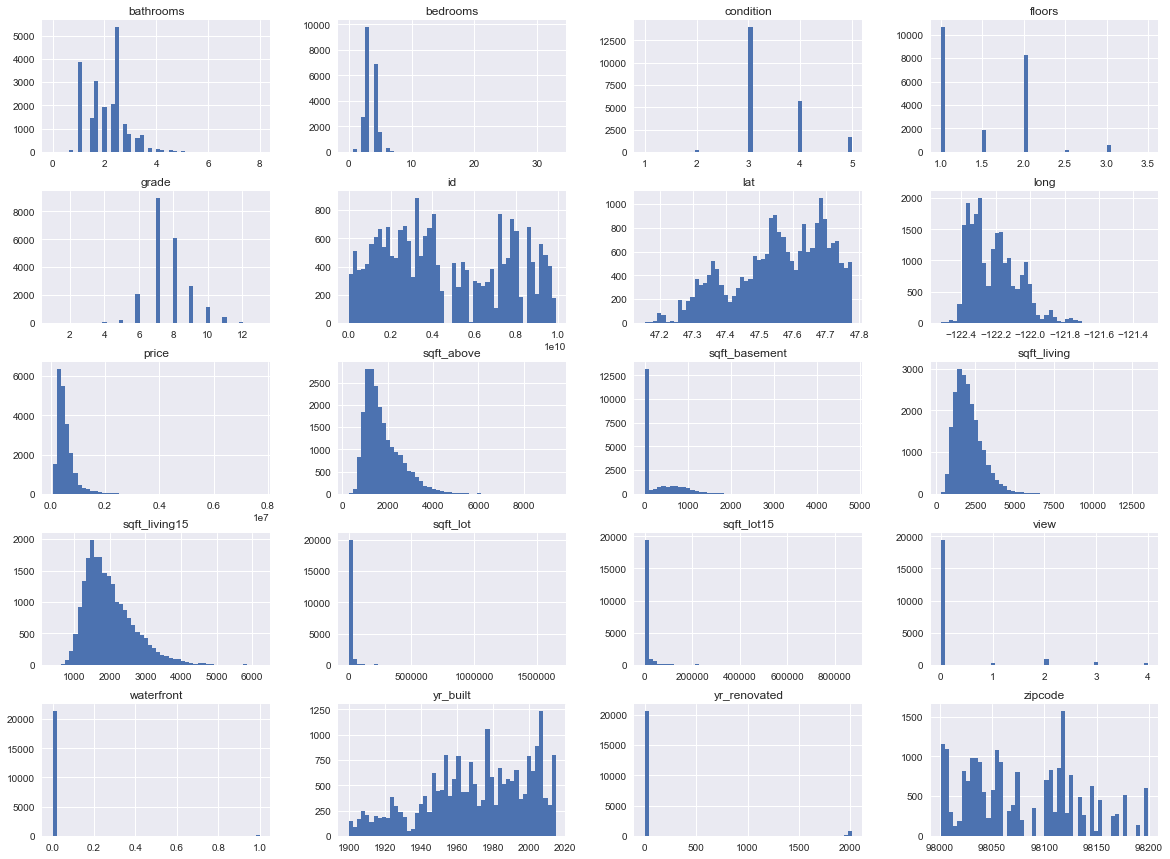

In [8]:
df.hist(bins = 50, figsize= (20, 15))
plt.show()

<h5>
<ol>
    <li>View DataFrame properties </li>
    <li>Calculate correlation for each column with every other column</li>
</ol>
</h5>

In [4]:
#df.info()
corrMatrix = df.corr()
corrMatrix["price"].sort_values(ascending = False)

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
id              -0.016762
zipcode         -0.053203
Name: price, dtype: float64

<h5>Plotting a correlation matrix to see which of the pairs have high correlation</h5>

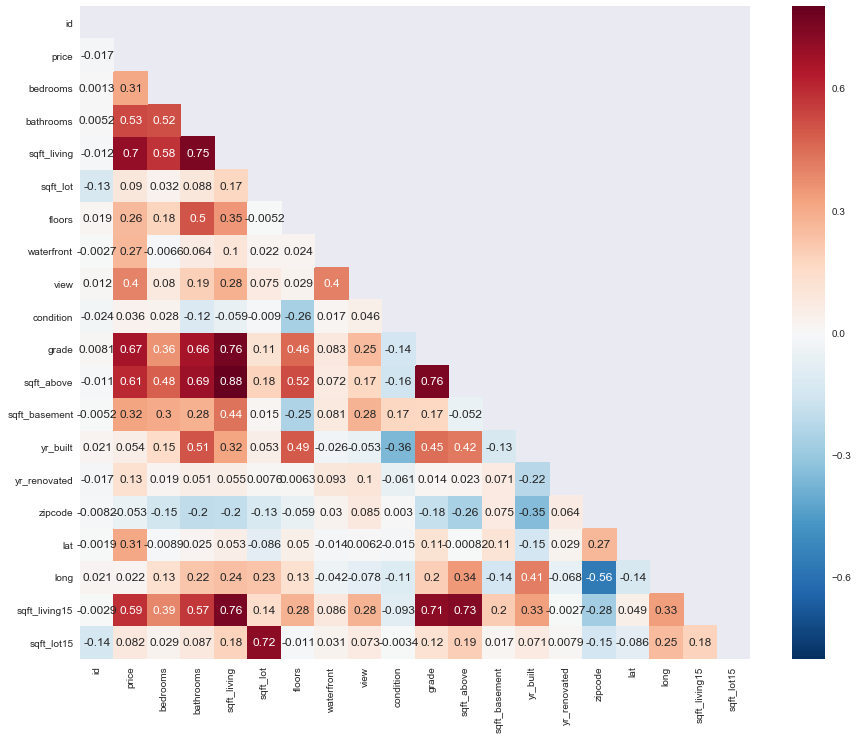

In [5]:
plt.figure(figsize=(15,12))

#Creating a array of zeros as the structure of corrMatrix
mask = np.zeros_like(corrMatrix)

#np.triu_indices_from returns the indices for the upper-triangle of an (n, m) array.
mask[np.triu_indices_from(mask)] = True

#mask = mask means the upper triangle coz its not needeed
sns.heatmap(corrMatrix, mask = mask , vmax = .8, square = False, annot = True)
sns.plt.show()

<h5>Setting y as 'Price' which we need to predict. </h5>

In [9]:
Y = df['price']

#Since y is already set as Price. We need to drop it from x
X = df.drop('price', axis = 1)

<h5>
<ol>
<li>Convert date to only year</li>
<li>Convert yr_renovated to years_since_renovation as years since renovation holds meaning and year as a whole doesnt make much sense</li>
<li>Convert categorical variable into dummy/indicator variables and concat them to original DataFrame </li>
</ol>
</h5>

In [10]:
#1
X['sold_year'] = X['date'].apply(lambda x: int(x[:4]))

#2
X['yrs_since_renovated'] = (X['sold_year'] - X['yr_renovated'][X['yr_renovated'] != 0]).fillna(0)

#3
zip_dummies = pd.get_dummies(X['zipcode'], prefix='zipcode')
X = pd.concat([X, zip_dummies], axis=1)

# Drop certain features now, revisit later to add
X = X.drop(['date', 'yr_renovated', 'sold_year', 'zipcode', 'id'], axis=1)

X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,0,0,0,0,0,0,1,0,0,0
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,0,0,0,0,0,0,0,0,0,0
2,2,1.00,770,10000,1.0,0,0,3,6,770,...,0,0,0,0,0,0,0,0,0,0
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,0,0,0,0,0,0,0,0,0,0
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,0,0,0,0,0,0,0,0,0,0


<h5>Transform X to polynomial features of degree 2 (because multiple features)</h5> 
<h5>Avoid using larger degree to avoid overfitting </h5>

In [11]:
# Create Polynomial Features
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)

#Manually fit training and test set
def split_train_test(data, test_ratio):
    np.random.seed(42) #So that it always generates the same set of shuffled indices
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(data, 0.2)
print "Training length: ", len(train_set)
print "Test length: ", len(test_set)


# Split train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X_poly, Y, test_size=0.2)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

#plt.plot(X_train, y_train, '.')

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

<h5>
<ol>
<li> Print train and test mean squared error </li>
<li> Print r2 (r - squared) - R-squared is a statistical measure of how close the data are to the fitted regression line</li>
</ol>
</h5>

In [12]:
from sklearn.metrics import r2_score

# Return MSE
print('Train set MSE: {}'.format(mean_squared_error(y_train, model.predict(X_train))))
print('Test set MSE: {}'.format(mean_squared_error(y_test, model.predict(X_test))))

# Return R^2
print('Train Score: {:.2f}'.format(model.score(X_train, y_train)))
print('Test Score: {:.2f}'.format(model.score(X_test, y_test)))

Train set MSE: 12450479383.7
Test set MSE: 32472973338.1
Train Score: 0.91
Test Score: 0.78
